In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [3]:
# X_data: scaling
X_train = X_train/255.
X_test = X_test/255.

In [4]:
# y_data: one hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [5]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [6]:
model = Sequential([ 
    Conv2D(32, (3,3), input_shape=X_train.shape[1:], padding='same', activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                        

In [7]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001, decay=1e-6),
    loss='categorical_crossentropy', metrics=['accuracy']
)

In [8]:
model_path = 'best-cifar10-v2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

 - 데이터 부풀리기

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,          # randomly rotate images in the range 15 degree
    width_shift_range=0.1,      # randomly shift images horizontally 
    height_shift_range=0.1,     # randomly shift images vertically
    shear_range=0.1,            # 도형의 기울기
    zoom_range=[0.8,1.2],       # 0.8~1.2 배 크기로 임의로 확대/축소
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # randomly flip images
    fill_mode='nearest'         # set mode for filling points outside the input boundaries
)

In [11]:
# data fitting
datagen.fit(X_train)

 - 데이터 부풀리기 한 결과로 학습시키기

In [12]:
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_valid, Y_valid),
    epochs=100, callbacks=[mc, es]
)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 1.8962 - accuracy: 0.2974
Epoch 1: val_loss improved from inf to 1.60860, saving model to best-cifar10-v2.h5
1250/1250 [==============================] - 36s 20ms/step - loss: 1.8962 - accuracy: 0.2974 - val_loss: 1.6086 - val_accuracy: 0.4160
Epoch 2/100
1248/1250 [============================>.] - ETA: 0s - loss: 1.6360 - accuracy: 0.4006
Epoch 2: val_loss improved from 1.60860 to 1.53812, saving model to best-cifar10-v2.h5
1250/1250 [==============================] - 26s 21ms/step - loss: 1.6361 - accuracy: 0.4006 - val_loss: 1.5381 - val_accuracy: 0.4399
Epoch 3/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.5387 - accuracy: 0.4373
Epoch 3: val_loss improved from 1.53812 to 1.38297, saving model to best-cifar10-v2.h5
1250/1250 [==============================] - 25s 20ms/step - loss: 1.5389 - accuracy: 0.4372 - val_loss: 1.3830 - val_accuracy: 0.5075
Epoch 4/100
1248/1250 [==================

In [13]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.7537 - accuracy: 0.7393


[0.7537194490432739, 0.739300012588501]

In [14]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

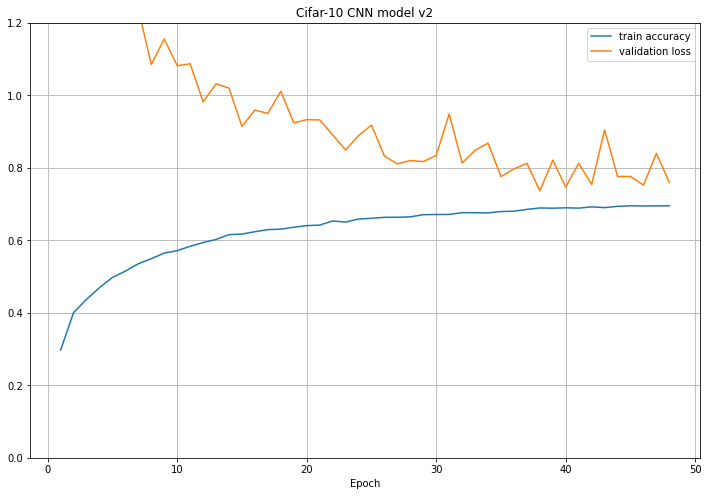

In [15]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid(), plt.ylim(0,1.2),
plt.xlabel('Epoch')
plt.title('Cifar-10 CNN model v2')
plt.show()